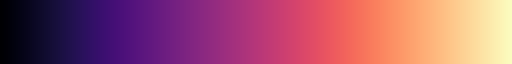

In [1]:
import numpy as np
import math
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import imgrvt as rvt
import pims
#import trackpy as tp
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels \
    import RBF, WhiteKernel
from matplotlib.patches import Circle
%config InlineBackend.figure_format='retina'
from scipy.signal import find_peaks
from scipy.signal import peak_widths
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rc('xtick', labelsize=8)      # fontsize of the tick labels
plt.rc('ytick', labelsize=8)      # fontsize of the tick labels 
from sympy import *
cmap = matplotlib.colormaps['viridis']
cmap
from colormath.color_objects import XYZColor, sRGBColor
from colormath.color_conversions import convert_color
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import time
from sklearn.gaussian_process.kernels import RBF
from scipy.interpolate import CubicSpline
import itertools
tab10 = plt.get_cmap("tab10")
hsv = plt.get_cmap("hsv")
cmap1 = matplotlib.colormaps['magma']
magma = plt.get_cmap("magma")
cmap1

In [9]:
#df = pd.read_csv('24.09.23 updating pH calibration v3 for drops dpHdt (23.11.14-15 f05 1000-2080) vfirst.csv')

In [97]:
df.head()

,Unnamed: 0,y,x,mass,size,ecc,signal,raw_mass,ep,frame,...,vacuole,time_label,pH,dt,dpH/dt,pHlow,pHhigh,delta,epsilon,avg pH
0,0,816.025937,1616.014409,0.323212,0.878826,0.287313,0.073584,0.325973,NaN,0,...,no,0,9.308535,0.167,-0.079971,9.268432,9.350179,0.700270,0.019732,9.300027
1,1,885.998206,430.007175,1.038564,0.886369,0.277397,0.222616,1.040733,NaN,0,...,no,0,9.126152,0.167,-0.094186,9.093584,9.159243,0.605546,0.018046,9.114744
2,2,921.990025,1026.044888,0.747021,0.883487,0.284345,0.163935,0.747748,NaN,0,...,no,0,9.230794,0.167,-0.047517,9.194406,9.268193,0.661408,0.019009,9.230103
3,3,928.044248,1664.013906,0.736775,0.879605,0.295752,0.166729,0.738834,NaN,0,...,no,0,9.304697,0.167,-0.036046,9.264799,9.346106,0.698412,0.019696,9.307976
4,4,946.055073,1180.973913,0.321350,0.881369,0.339552,0.071721,0.324027,NaN,0,...,yes,0,9.239690,0.167,-0.012736,9.202912,9.277532,0.665981,0.019095,9.247325


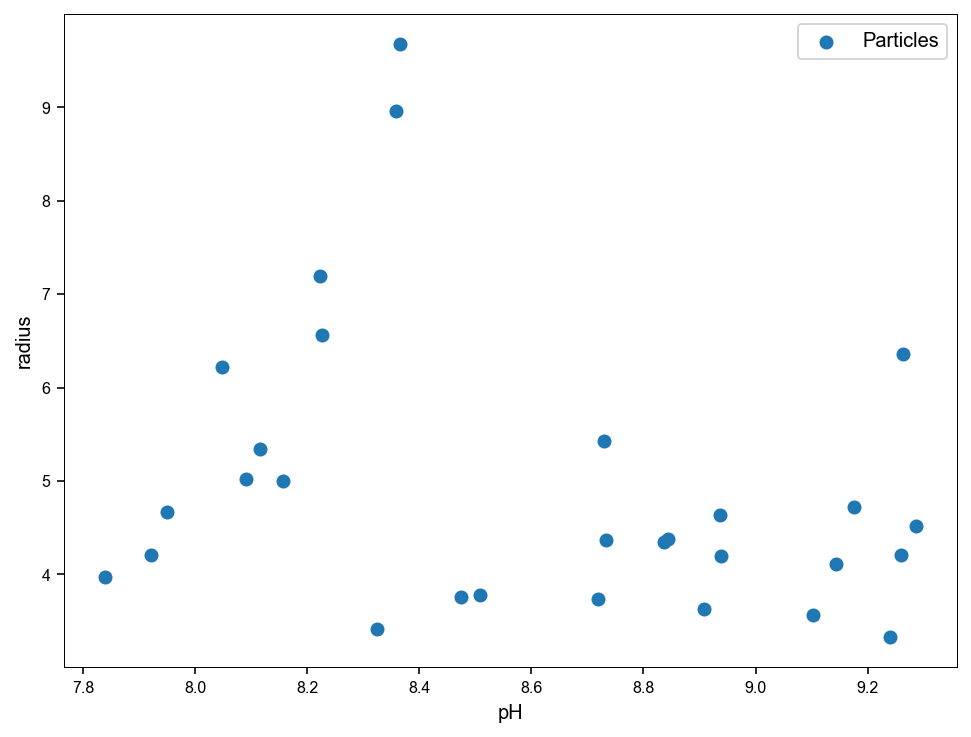

In [98]:
# filter particles with 'vacuole' = 'yes' for more than 3 frames
particle_vacuole_counts = df[df['vacuole'] == 'yes'].groupby('particle').size()
qualified_particles = particle_vacuole_counts[particle_vacuole_counts >= 3].index

# filter the original df based on selected particles
filtered_df = df[df['particle'].isin(qualified_particles)]

# find the first occurrence of vsignal > 1.2 for each qualified particle
particle_no = []
first_vsignal = []
pH_values = []
dpHdt_values = []
radius_values = []

for particle in qualified_particles:
    particle_data = filtered_df[(filtered_df['particle'] == particle) & (filtered_df['vsignal'] > 1.2)]
    if not particle_data.empty:
        particle_no.append(particle_data['particle'].iloc[0])
        
        first_vsignal.append(particle_data['vsignal'].iloc[0])
        
        pH_values.append(particle_data['pH'].iloc[0])
        
        dpHdt_values.append(particle_data['dpH/dt'].iloc[0])
        
        radius_values.append(particle_data['radius'].iloc[0])

plt.figure(figsize=(8, 6))

plt.scatter(pH_values, radius_values, label='Particles')

#plt.axhline(y=1.2, color='red', linestyle='--', label='Vsignal = 1.2')

plt.xlabel('pH')
plt.ylabel('radius')
#plt.title('pH vs First Vsignal > 1.2 for Particles with Vacuole Formation f09')
plt.legend()
plt.show()


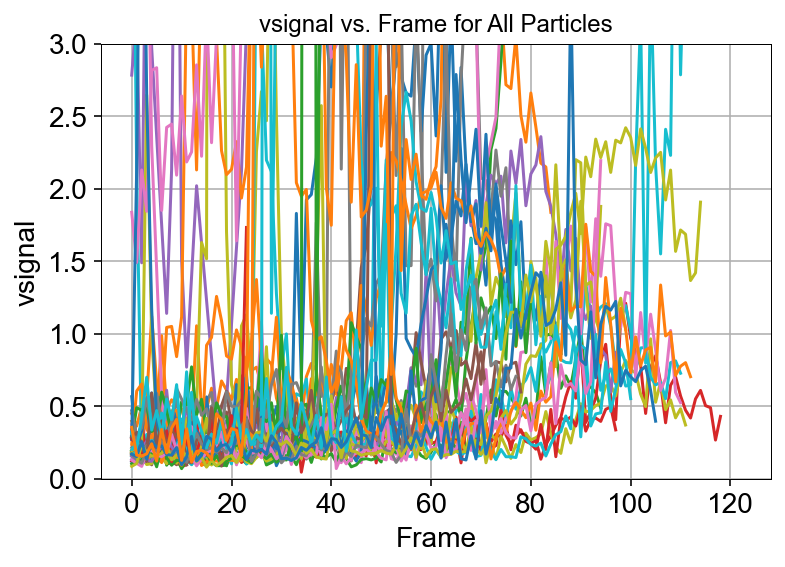

In [99]:
particles = df['particle'].unique()

plt.figure()  
plt.title('vsignal vs. Frame for All Particles')
plt.xlabel('Frame')
plt.ylabel('vsignal')
#plt.ylim(0,1.4)

for particle in particles:
    index_radius = (df['particle']==particle) & (df['frame']==0)
    radius_ini = df[index_radius]['radius'].values
    if radius_ini > 3.2:
        particle_data = df[df['particle'] == particle]
        plt.plot(particle_data['frame'], particle_data['vsignal'], label=f'Particle {particle}')

        
plt.xlabel('Frame', fontsize = 14)
plt.ylabel('vsignal', fontsize = 14)
plt.xticks(fontsize =14)
plt.yticks(fontsize =14)            

#plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.ylim(0,3)
plt.show()



In [100]:
qualified_particles

Index([ 2,  6,  7,  9, 10, 11, 12, 13, 14, 16, 18, 19, 20, 24, 25, 26, 27, 32,
       33, 34, 36, 37, 38, 40, 44, 47, 48, 49, 50],
      dtype='int64', name='particle')

## this file gets modified with the additional columns

In [104]:
csv_file_path = '24.09.23 updating pH calibration v3 for drops dphdt (24.04.01 f03 0 to 1500) all vfirst.csv'

# Read the existing CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

df.head()

,Unnamed: 0,y,x,mass,size,ecc,signal,raw_mass,ep,frame,...,pHlow,pHhigh,delta,epsilon,avg pH,particle_vfirst,pH_vfirst,dpHdt_vfirst,vfirst,radius_vfirst
0,0,566.952978,332.048589,0.322689,0.880830,0.278788,0.072327,0.323828,NaN,0,...,9.658772,9.831922,0.862947,0.023377,9.713470,3.0,9.730901,0.316291,2.664153,3.718215
1,1,593.003861,857.009653,0.261995,0.890750,0.267640,0.054119,0.263544,NaN,0,...,9.651645,9.822218,0.860700,0.023353,9.754301,7.0,7.969071,-0.041787,1.219954,8.049470
2,2,607.970000,789.027143,0.354048,0.881557,0.275735,0.078902,0.354479,NaN,0,...,9.658981,9.832551,0.863052,0.023417,9.758650,8.0,9.733592,-0.005601,19.392466,5.658617
3,3,654.978858,1331.000000,0.478471,0.885638,0.261456,0.103180,0.479759,NaN,0,...,9.663354,9.838870,0.864456,0.023470,9.761203,9.0,9.635020,-0.139237,25.973962,3.458340
4,4,732.994469,652.023230,0.457228,0.884978,0.279661,0.099133,0.459025,NaN,0,...,9.682374,9.865708,0.870343,0.023587,9.734188,10.0,9.713420,-0.027985,10.874197,4.688416


In [102]:
# Pad the list with NaN to match the length of the DataFrame
particle_no_v2 = particle_no + [np.nan] * (len(df) - len(first_vsignal))

# Add a new column named 'particle_vfirst' with the values from the padded list
df['particle_vfirst'] = particle_no_v2

pH_values_v2 = pH_values + [np.nan] * (len(df) - len(first_vsignal))
df['pH_vfirst'] = pH_values_v2

dpHdt_values_v2 = dpHdt_values + [np.nan] * (len(df) - len(first_vsignal))
df['dpHdt_vfirst'] = dpHdt_values_v2

first_vsignal_v2 = first_vsignal + [np.nan] * (len(df) - len(first_vsignal))
df['vfirst'] = first_vsignal_v2

radius_values_v2 = radius_values + [np.nan] * (len(df) - len(first_vsignal))
df['radius_vfirst'] = radius_values_v2


# Save the DataFrame back to the CSV file
df.to_csv(csv_file_path, index=False)

In [103]:
df.head()

,Unnamed: 0,y,x,mass,size,ecc,signal,raw_mass,ep,frame,...,pHlow,pHhigh,delta,epsilon,avg pH,particle_vfirst,pH_vfirst,dpHdt_vfirst,vfirst,radius_vfirst
0,0,816.025937,1616.014409,0.323212,0.878826,0.287313,0.073584,0.325973,NaN,0,...,9.268432,9.350179,0.700270,0.019732,9.300027,2.0,8.227098,-0.112190,4.581338,6.562628
1,1,885.998206,430.007175,1.038564,0.886369,0.277397,0.222616,1.040733,NaN,0,...,9.093584,9.159243,0.605546,0.018046,9.114744,6.0,9.239690,-0.012736,2.783381,3.330846
2,2,921.990025,1026.044888,0.747021,0.883487,0.284345,0.163935,0.747748,NaN,0,...,9.194406,9.268193,0.661408,0.019009,9.230103,7.0,8.366417,-0.126480,1.452962,9.679502
3,3,928.044248,1664.013906,0.736775,0.879605,0.295752,0.166729,0.738834,NaN,0,...,9.264799,9.346106,0.698412,0.019696,9.307976,9.0,7.838943,-0.174328,7.072715,3.977202
4,4,946.055073,1180.973913,0.321350,0.881369,0.339552,0.071721,0.324027,NaN,0,...,9.202912,9.277532,0.665981,0.019095,9.247325,10.0,9.102928,-0.076495,1.628632,3.560661


## checking radius increase vs visgnal increase

In [13]:
df = pd.read_csv('24.09.23 updating pH calibration v3 for drops dpHdt (23.11.14-15 f05 1000-2080) vfirst.csv')

In [14]:
df

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,...,pHlow,pHhigh,delta,epsilon,avg pH,particle_vfirst,pH_vfirst,dpHdt_vfirst,vfirst,radius_vfirst
0,895.969574,397.957404,0.381972,0.882556,0.268229,0.084452,0.384567,NaN,0,2,...,9.509890,9.928562,0.847387,0.059503,9.639186,2.0,NaN,NaN,1.884696,3.645213
1,896.982456,871.937622,0.397468,0.879704,0.279597,0.089876,0.398800,NaN,0,3,...,9.527633,9.970048,0.854641,0.060009,9.674045,3.0,NaN,NaN,2.762589,4.104548
2,954.960784,992.986928,0.118543,0.885615,0.308333,0.025568,0.120414,NaN,0,4,...,9.515009,9.941192,0.849582,0.059735,9.691227,5.0,7.220944,-0.666012,1.345058,5.009299
3,1040.043299,656.956701,0.751548,0.876968,0.281501,0.173553,0.753675,NaN,0,5,...,9.485145,9.874640,0.837035,0.058829,9.661236,6.0,6.860659,-0.952527,1.689387,3.888800
4,1255.012674,125.000000,0.611310,0.882157,0.255700,0.135588,0.613096,NaN,0,6,...,9.456922,9.817145,0.824818,0.058032,9.617692,8.0,5.968894,NaN,1.226550,3.777446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3351,1027.017032,673.007299,0.143311,0.890611,0.268916,0.029639,0.143555,NaN,132,5,...,NaN,NaN,-0.055325,0.029096,NaN,NaN,NaN,NaN,NaN,NaN
3352,1028.953139,671.997348,0.145678,0.880077,0.279680,0.032845,0.145862,NaN,133,5,...,NaN,NaN,-0.056688,0.029071,NaN,NaN,NaN,NaN,NaN,NaN
3353,1026.999166,671.987490,0.117318,0.887312,0.255297,0.024951,0.117536,NaN,134,5,...,NaN,NaN,-0.055970,0.029083,NaN,NaN,NaN,NaN,NaN,NaN
3354,1027.005025,673.027638,0.128466,0.886810,0.274760,0.027436,0.128670,NaN,135,5,...,NaN,NaN,-0.057142,0.029065,NaN,NaN,NaN,NaN,NaN,NaN


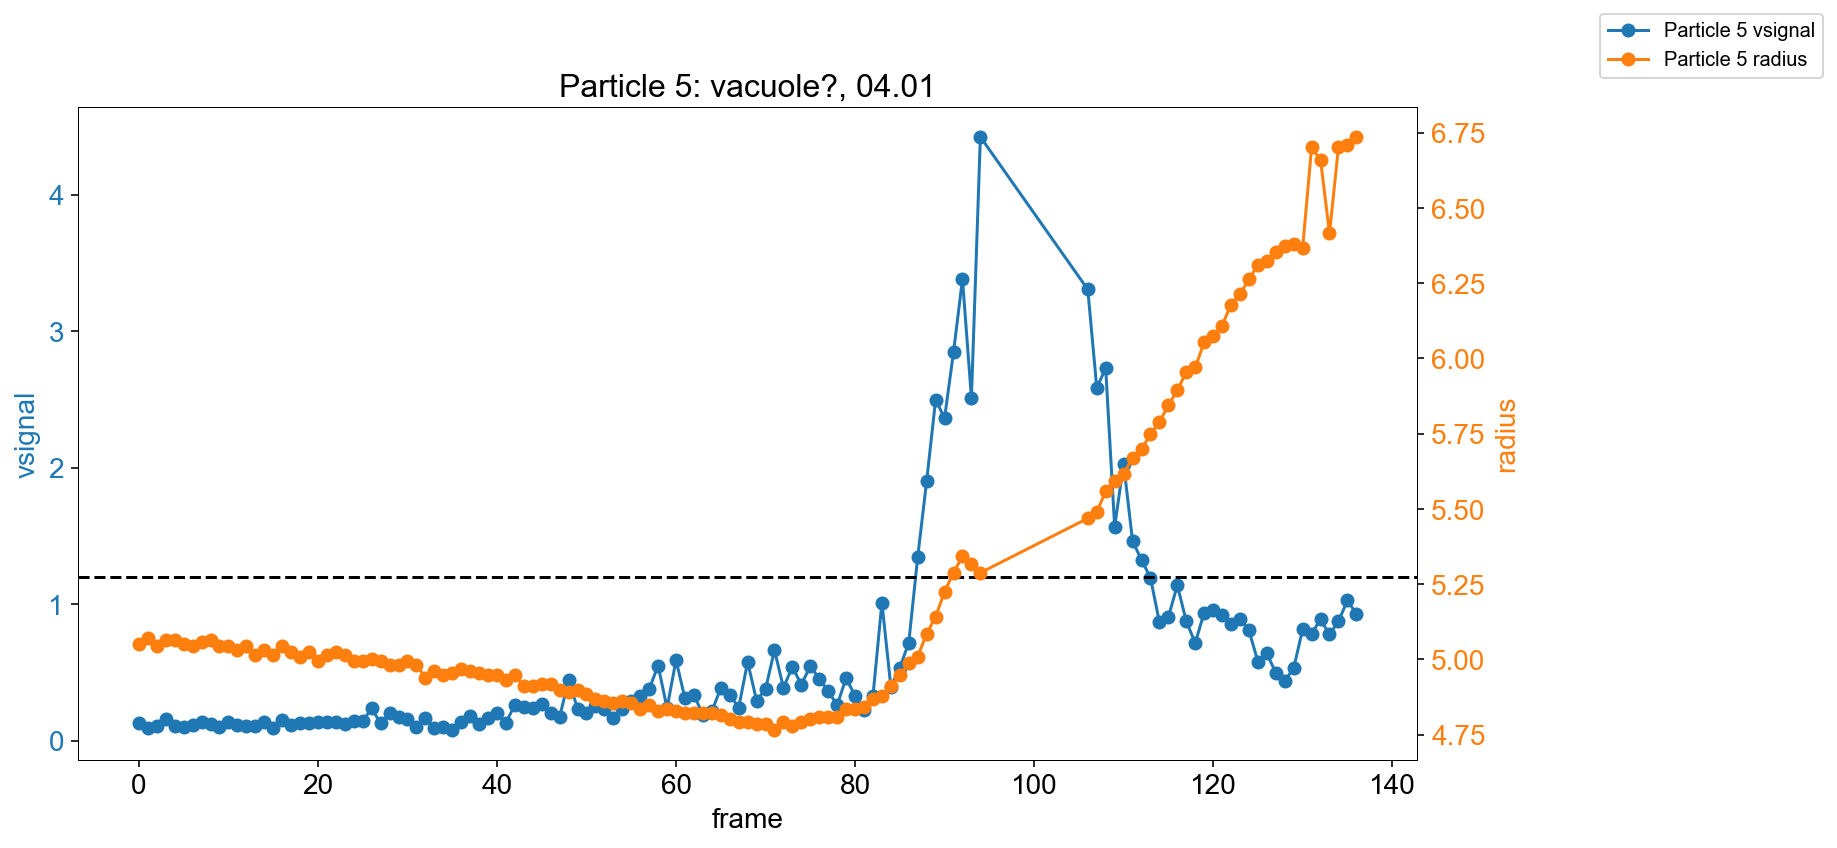

In [15]:
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the 'vsignal' data on the first y-axis (left)
particle = 5
mask = df['particle'] == particle
data = df[mask]
ax1.plot(data['frame'], data['vsignal'], '-o', label=f'Particle {particle} vsignal', color='tab:blue')

# Set the labels and axis properties for the first y-axis
ax1.set_xlabel('frame', fontsize=14)
ax1.set_ylabel('vsignal', fontsize=14, color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue',)
ax1.tick_params(axis='y', labelsize=14)
ax1.tick_params(axis='x', labelsize=14)
ax1.axhline(y=1.2, color='k', linestyle='--')

# Create a second y-axis (right) and plot the 'radius' data
ax2 = ax1.twinx()
ax2.plot(data['frame'], data['radius'], '-o', label=f'Particle {particle} radius', color='tab:orange')

# Set the labels and axis properties for the second y-axis
ax2.set_ylabel('radius', fontsize=14, color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')
ax2.tick_params(axis='y', labelsize=14)

# Create legends for both datasets
fig.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.title(f'Particle {particle}: vacuole?, 04.01', fontsize=16)

# Show the plot
plt.show()


## any one quantity

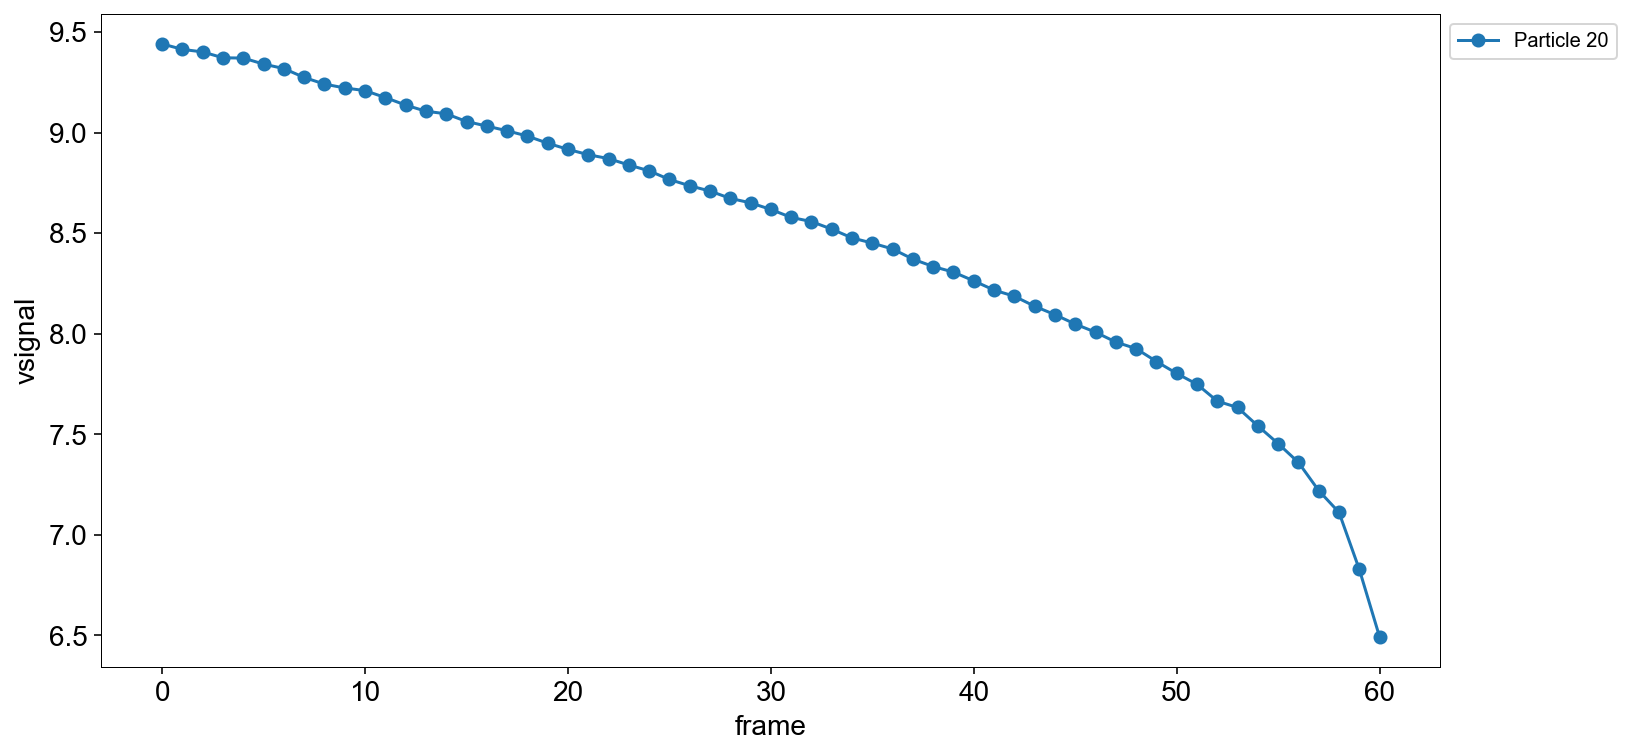

In [7]:
plt.figure(figsize=(12, 6))

particle = 20
mask = df['particle'] == particle
data = df[mask]
plt.plot(data['frame'], data['pH'], '-o', label=f'Particle {particle}')


plt.xlabel('frame', fontsize = 14)
plt.ylabel('vsignal', fontsize = 14)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
#plt.axhline(y=1.2, color='k')

plt.show()


